In [1]:
import os
import cv2
import math
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, fbeta_score
from keras import optimizers
from keras import backend as K
from keras.models import Sequential, Model
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Activation, BatchNormalization, GlobalAveragePooling2D, Input

# Set seeds to make the experiment more reproducible.
from tensorflow import set_random_seed
from numpy.random import seed
set_random_seed(0)
seed(0)

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
train = pd.read_csv('../input/imet-2019-fgvc6/train.csv')
labels = pd.read_csv('../input/imet-2019-fgvc6/labels.csv')
test = pd.read_csv('../input/imet-2019-fgvc6/sample_submission.csv')

train["attribute_ids"] = train["attribute_ids"].apply(lambda x:x.split(" "))
train["id"] = train["id"].apply(lambda x: x + ".png")
test["id"] = test["id"].apply(lambda x: x + ".png")

print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])
print('Number of labels: ', labels.shape[0])
display(train.head())
display(labels.head())

Number of train samples:  109237
Number of test samples:  7443
Number of labels:  1103


,id,attribute_ids
0,1000483014d91860.png,"[147, 616, 813]"
1,1000fe2e667721fe.png,"[51, 616, 734, 813]"
2,1001614cb89646ee.png,[776]
3,10041eb49b297c08.png,"[51, 671, 698, 813, 1092]"
4,100501c227f8beea.png,"[13, 404, 492, 903, 1093]"


,attribute_id,attribute_name
0,0,culture::abruzzi
1,1,culture::achaemenid
2,2,culture::aegean
3,3,culture::afghan
4,4,culture::after british


### Model parameters

In [3]:
# Model parameters
BATCH_SIZE = 64
EPOCHS = 10
WARMUP_EPOCHS = 2
LEARNING_RATE = 0.001
WARMUP_LEARNING_RATE = 0.001
HEIGHT = 156
WIDTH = 156
CANAL = 3
N_CLASSES = labels.shape[0]
ES_PATIENCE = 4
RLROP_PATIENCE = 2
DECAY_DROP = 0.5
DECAY_EPOCHS = 10

In [4]:
def f2_score_thr(threshold=0.5):
    def f2_score(y_true, y_pred):
        beta = 2
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold), K.floatx())

        true_positives = K.sum(K.clip(y_true * y_pred, 0, 1), axis=1)
        predicted_positives = K.sum(K.clip(y_pred, 0, 1), axis=1)
        possible_positives = K.sum(K.clip(y_true, 0, 1), axis=1)

        precision = true_positives / (predicted_positives + K.epsilon())
        recall = true_positives / (possible_positives + K.epsilon())

        return K.mean(((1+beta**2)*precision*recall) / ((beta**2)*precision+recall+K.epsilon()))
    return f2_score


def custom_f2(y_true, y_pred):
    beta = 2

    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f2 = (1+beta**2)*p*r / (p*beta**2 + r + 1e-15)

    return f2

def step_decay(epoch):
    initial_lrate = LEARNING_RATE
    drop = DECAY_DROP
    epochs_drop = DECAY_EPOCHS
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    
    return lrate

In [5]:
# reference link: https://gist.github.com/drscotthawley/d1818aabce8d1bf082a6fb37137473ae
def get_1cycle_schedule(lr_max=1e-3, n_data_points=8000, epochs=200, batch_size=40, verbose=0):          
    """
    Creates a look-up table of learning rates for 1cycle schedule with cosine annealing
    See @sgugger's & @jeremyhoward's code in fastai library: https://github.com/fastai/fastai/blob/master/fastai/train.py
    Wrote this to use with my Keras and (non-fastai-)PyTorch codes.
    Note that in Keras, the LearningRateScheduler callback (https://keras.io/callbacks/#learningratescheduler) only operates once per epoch, not per batch
      So see below for Keras callback

    Keyword arguments:
    lr_max            chosen by user after lr_finder
    n_data_points     data points per epoch (e.g. size of training set)
    epochs            number of epochs
    batch_size        batch size
    Output:  
    lrs               look-up table of LR's, with length equal to total # of iterations
    Then you can use this in your PyTorch code by counting iteration number and setting
          optimizer.param_groups[0]['lr'] = lrs[iter_count]
    """
    if verbose > 0:
        print("Setting up 1Cycle LR schedule...")
    pct_start, div_factor = 0.3, 25.        # @sgugger's parameters in fastai code
    lr_start = lr_max/div_factor
    lr_end = lr_start/1e4
    n_iter = (n_data_points * epochs // batch_size) + 1    # number of iterations
    a1 = int(n_iter * pct_start)
    a2 = n_iter - a1

    # make look-up table
    lrs_first = np.linspace(lr_start, lr_max, a1)            # linear growth
    lrs_second = (lr_max-lr_end)*(1+np.cos(np.linspace(0,np.pi,a2)))/2 + lr_end  # cosine annealing
    lrs = np.concatenate((lrs_first, lrs_second))
    return lrs


class OneCycleScheduler(Callback):
    """My modification of Keras' Learning rate scheduler to do 1Cycle learning
       which increments per BATCH, not per epoch
    Keyword arguments
        **kwargs:  keyword arguments to pass to get_1cycle_schedule()
        Also, verbose: int. 0: quiet, 1: update messages.

    Sample usage (from my train.py):
        lrsched = OneCycleScheduler(lr_max=1e-4, n_data_points=X_train.shape[0],
        epochs=epochs, batch_size=batch_size, verbose=1)
    """
    def __init__(self, **kwargs):
        super(OneCycleScheduler, self).__init__()
        self.verbose = kwargs.get('verbose', 0)
        self.lrs = get_1cycle_schedule(**kwargs)
        self.iteration = 0

    def on_batch_begin(self, batch, logs=None):
        lr = self.lrs[self.iteration]
        K.set_value(self.model.optimizer.lr, lr)         # here's where the assignment takes place
        if self.verbose > 0:
            print('\nIteration %06d: OneCycleScheduler setting learning '
                  'rate to %s.' % (self.iteration, lr))
        self.iteration += 1

    def on_epoch_end(self, epoch, logs=None):  # this is unchanged from Keras LearningRateScheduler
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)
        self.iteration = 0

In [6]:
train_datagen=ImageDataGenerator(rescale=1./255, validation_split=0.25,
                                 shear_range=0.2, 
                                 width_shift_range=0.2, 
                                 height_shift_range=0.2, 
                                 brightness_range=[0.5, 1.2], 
                                 horizontal_flip=True, 
                                 fill_mode='nearest')

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="../input/imet-2019-fgvc6/train",
    x_col="id",
    y_col="attribute_ids",
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode="categorical",
    target_size=(HEIGHT, WIDTH),
    subset='training')

valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="../input/imet-2019-fgvc6/train",
    x_col="id",
    y_col="attribute_ids",
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode="categorical",    
    target_size=(HEIGHT, WIDTH),
    subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(  
        dataframe=test,
        directory = "../input/imet-2019-fgvc6/test",    
        x_col="id",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

Found 81928 images belonging to 1103 classes.
Found 27309 images belonging to 1103 classes.
Found 7443 images.


### Model

In [7]:
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = applications.Xception(weights=None, include_top=False,
                   input_tensor=input_tensor)
    base_model.load_weights('../input/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5')

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='sigmoid', name='final_output')(x)
    model = Model(input_tensor, final_output)
    
    return model

In [8]:
model = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

for layer in model.layers:
    layer.trainable = False

for i in range(-5,0):
    model.layers[i].trainable = True

metrics = ["accuracy", "categorical_accuracy"]
optimizer = optimizers.Adam(lr=WARMUP_LEARNING_RATE)
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=metrics)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 156, 156, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 77, 77, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 77, 77, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Act

#### Train top layers

In [9]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs=WARMUP_EPOCHS,
                              verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/2
 - 1627s - loss: 0.0196 - acc: 0.9963 - categorical_accuracy: 0.0843 - val_loss: 0.0127 - val_acc: 0.9972 - val_categorical_accuracy: 0.1330
Epoch 2/2
 - 1633s - loss: 0.0128 - acc: 0.9972 - categorical_accuracy: 0.1190 - val_loss: 0.0121 - val_acc: 0.9972 - val_categorical_accuracy: 0.1301


#### Fine-tune the complete model

In [10]:
for layer in model.layers:
    layer.trainable = True

# lrate = LearningRateScheduler(step_decay)
es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint('../working/Xcecption_step1.h5', monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True, verbose=1)
lrsched = OneCycleScheduler(lr_max=LEARNING_RATE, n_data_points=train_generator.n, epochs=1, batch_size=BATCH_SIZE, verbose=0)

callbacks = [es, lrsched]
optimizer = optimizers.Adam(lr=LEARNING_RATE)
metrics = ["accuracy"]
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=metrics)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 156, 156, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 77, 77, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 77, 77, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 77, 77, 32)   0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [11]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs=EPOCHS,
                              callbacks=callbacks,
                              verbose=2)

Epoch 1/10
 - 1759s - loss: 0.0111 - acc: 0.9973 - val_loss: 0.0098 - val_acc: 0.9975
Epoch 2/10
 - 1741s - loss: 0.0104 - acc: 0.9974 - val_loss: 0.0095 - val_acc: 0.9975
Epoch 3/10
 - 1744s - loss: 0.0100 - acc: 0.9975 - val_loss: 0.0093 - val_acc: 0.9976
Epoch 4/10
 - 1738s - loss: 0.0097 - acc: 0.9975 - val_loss: 0.0091 - val_acc: 0.9976
Epoch 5/10
 - 1709s - loss: 0.0095 - acc: 0.9975 - val_loss: 0.0090 - val_acc: 0.9976
Epoch 6/10
 - 1699s - loss: 0.0093 - acc: 0.9976 - val_loss: 0.0089 - val_acc: 0.9977
Epoch 7/10
 - 1726s - loss: 0.0091 - acc: 0.9976 - val_loss: 0.0088 - val_acc: 0.9977
Epoch 8/10
 - 1755s - loss: 0.0089 - acc: 0.9976 - val_loss: 0.0087 - val_acc: 0.9977
Epoch 9/10
 - 1740s - loss: 0.0088 - acc: 0.9977 - val_loss: 0.0086 - val_acc: 0.9977
Epoch 10/10
 - 1718s - loss: 0.0086 - acc: 0.9977 - val_loss: 0.0086 - val_acc: 0.9977


### Complete model graph loss

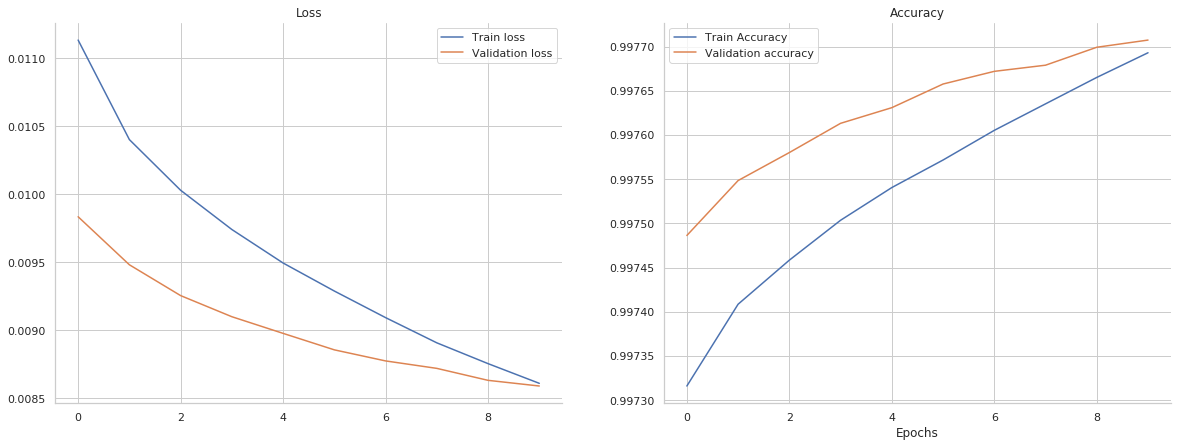

In [12]:
sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(20,7))

ax1.plot(history.history['loss'], label='Train loss')
ax1.plot(history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history.history['acc'], label='Train Accuracy')
ax2.plot(history.history['val_acc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

### Find best threshold value

In [13]:
lastFullValPred = np.empty((0, N_CLASSES))
lastFullValLabels = np.empty((0, N_CLASSES))

for i in range(STEP_SIZE_VALID+1):
    im, lbl = next(valid_generator)
    scores = model.predict(im, batch_size=valid_generator.batch_size)
    lastFullValPred = np.append(lastFullValPred, scores, axis=0)
    lastFullValLabels = np.append(lastFullValLabels, lbl, axis=0)
    
print(lastFullValPred.shape, lastFullValLabels.shape)

(27309, 1103) (27309, 1103)


thr=0.120 F2=0.518


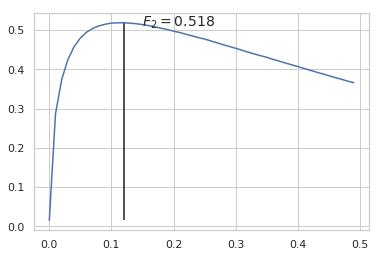

In [14]:
def find_best_fixed_threshold(preds, targs, do_plot=True):
    score = []
    thrs = np.arange(0, 0.5, 0.01)
    for thr in thrs:
        score.append(custom_f2(targs, (preds > thr).astype(int)))
    score = np.array(score)
    pm = score.argmax()
    best_thr, best_score = thrs[pm], score[pm].item()
    print(f'thr={best_thr:.3f}', f'F2={best_score:.3f}')
    if do_plot:
        plt.plot(thrs, score)
        plt.vlines(x=best_thr, ymin=score.min(), ymax=score.max())
        plt.text(best_thr+0.03, best_score-0.01, f'$F_{2}=${best_score:.3f}', fontsize=14);
        plt.show()
    return best_thr, best_score

threshold, best_score = find_best_fixed_threshold(lastFullValPred, lastFullValLabels, do_plot=True)

### Apply model to test set and output predictions

In [15]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST)

In [16]:
predictions = []
for pred_ar in preds:
    valid = []
    for idx, pred in enumerate(pred_ar):
        if pred > threshold:
            valid.append(idx)
    if len(valid) == 0:
        valid.append(np.argmax(pred_ar))
    predictions.append(valid)

In [17]:
filenames = test_generator.filenames
label_map = {valid_generator.class_indices[k] : k for k in valid_generator.class_indices}

results = pd.DataFrame({'id':filenames, 'attribute_ids':predictions})
results['id'] = results['id'].map(lambda x: str(x)[:-4])
results['attribute_ids'] = results['attribute_ids'].apply(lambda x: list(map(label_map.get, x)))
results["attribute_ids"] = results["attribute_ids"].apply(lambda x: ' '.join(x))
results.to_csv('submission.csv',index=False)
results.head(10)

,id,attribute_ids
0,10023b2cc4ed5f68,1059 195 223 369 587 766
1,100fbe75ed8fd887,1039 188 226 231
2,101b627524a04f19,121 415 704 735 813 961
3,10234480c41284c6,1046 13 147 480 483 51 738 776 813 963 975
4,1023b0e2636dcea8,1046 1092 147 156 227 29 322 383 489 584 671 8...
5,1039cd6cf85845c,1092 13 405 896 903
6,103a5b3f83fbe88,1092 194 404 744 813
7,10413aaae8d6a9a2,1092 147 51 813 896
8,10423822b93a65ab,1039 1059 121 369
9,1052bf702cb099f7,1002 188 335 597 671 780
